In [22]:
#! /usr/bin/env python3

%load_ext autoreload
# %autoreload 0
%autoreload

from __future__ import annotations

import warnings
from itertools import product

from tqdm.auto import tqdm
import numpy as np
import torch

import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow

# from pyaarapsi.vpr_simple.vpr_helpers import FeatureType
from pyaarapsi.vpr.classes.vprdescriptor import VPRDescriptor
from pyaarapsi.core.enum_tools import enum_get

from pyaarapsi.nn.colours import royal_purple, drk_mss_grn, slate_blue, custom_red, gg_bridge
from pyaarapsi.nn.nn_helpers import get_td_from_am, get_model_for
from pyaarapsi.nn.enums import TrainData, ApplyModel
from pyaarapsi.nn.visualize import get_acc_and_confusion_stats, plot_confusion_bars
from pyaarapsi.nn.params import General, DFGeneral, DFNNTrain, DFNNTest, NNGeneral
from adversity import AdversityGenerationMethods

from experiment_functions import generate_svm_data, generate_test_data

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
np.seterr(divide='ignore', invalid='ignore')
matplotlib.rcParams['figure.dpi'] = 100

# Parameters
DF_GENERAL  = DFGeneral()
GENERAL     = General()
NN_GENERAL  = NNGeneral()
DF_NN_TRAIN = DFNNTrain()
DF_NN_TEST  = DFNNTest()

# Remove encoder topic because this file only accepts singular topic
DF_GENERAL.VPR.ODOM_TOPICS = [DF_GENERAL.VPR.ODOM_TOPIC]
for descriptor_type in DFGeneral.DESCRIPTOR_TYPES:
    DFGeneral.TRAIN_REF_SUBSETS[descriptor_type.name]['odom_topics'] = (DF_GENERAL.VPR.ODOM_TOPIC,)
    DFGeneral.TRAIN_QRY_SUBSETS[descriptor_type.name]['odom_topics'] = (DF_GENERAL.VPR.ODOM_TOPIC,)
    DFGeneral.TEST_REF_SUBSETS[descriptor_type.name]['odom_topics'] = (DF_GENERAL.VPR.ODOM_TOPIC,)
    DFGeneral.TEST_QRY_SUBSETS[descriptor_type.name]['odom_topics'] = (DF_GENERAL.VPR.ODOM_TOPIC,)
    DFGeneral.SVM_SUBSETS[descriptor_type.name]['ref_subset']['odom_topics'] = (DF_GENERAL.VPR.ODOM_TOPIC,)
    DFGeneral.SVM_SUBSETS[descriptor_type.name]['qry_subset']['odom_topics'] = (DF_GENERAL.VPR.ODOM_TOPIC,)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Train

Fully trained model loaded (nn_20250324).


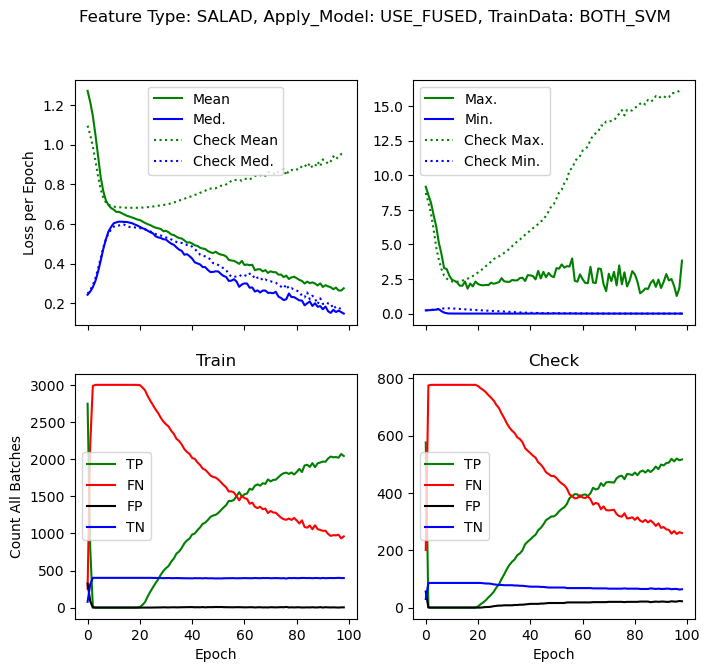

Fully trained model loaded (nn_20250323).


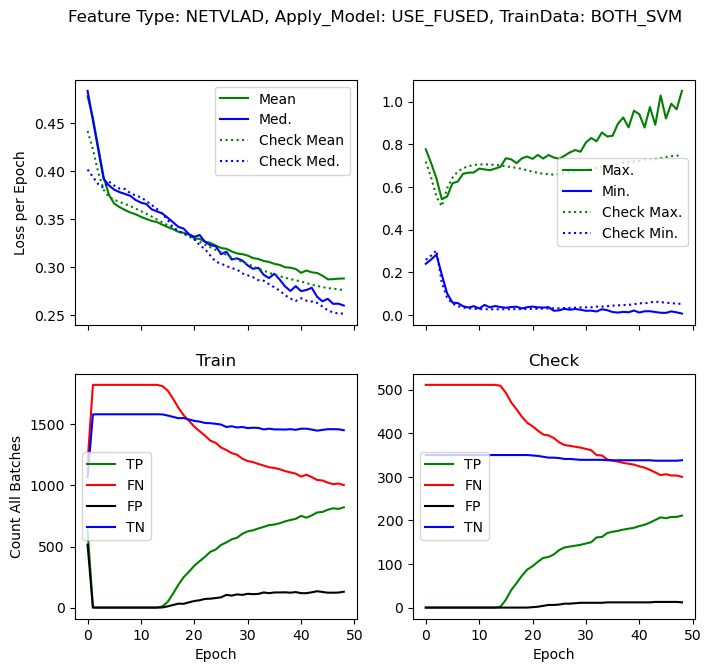

Fully trained model loaded (nn_20250319).


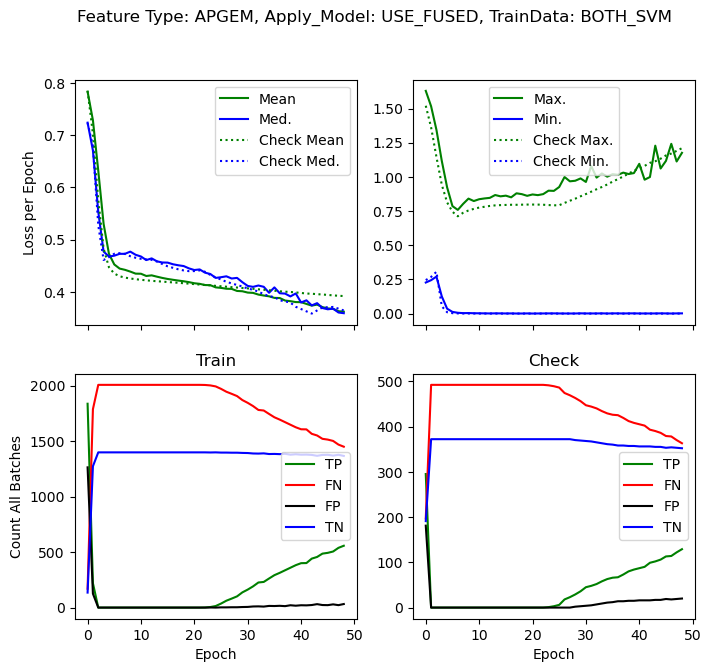

In [23]:
%matplotlib inline
SHOW_PLOTS = True
if True:
    train_datas    = [enum_get(value=i, enumtype=TrainData, wrap=False) 
                        for i in set([
                            get_td_from_am(env='Office', apply_model=DF_NN_TRAIN.APPLY_MODEL).name, 
                            get_td_from_am(env='Campus', apply_model=DF_NN_TRAIN.APPLY_MODEL).name
                            ])]
    figs = []
    figsize = (8,7)
    for train_data, feature_type in product(train_datas, DF_GENERAL.DESCRIPTOR_TYPES[::-1]):
        train_model, train_model_osh = get_model_for(train_data=train_data,
            datagen=AdversityGenerationMethods, vpr_descriptor=feature_type, nn_general=NN_GENERAL,
            df_nn_train=DF_NN_TRAIN, general=GENERAL, allow_generate=True)
        
        train_model_out  = train_model_osh.get_object()['output']
        max_epoch        = DF_NN_TRAIN.MAX_EPOCH[feature_type]
        
        train_losses = np.array(train_model_out['train']['loss'][:max_epoch])
        check_losses = np.array(train_model_out['check']['loss'][:max_epoch])

        train_bin_labels  = np.array(train_model_out['train']['labels_bin'][:max_epoch])
        train_bin_preds   = np.array(train_model_out['train']['pred'][:max_epoch])
        check_bin_labels  = np.array(train_model_out['check']['labels_bin'][:max_epoch])
        check_bin_preds   = np.array(train_model_out['check']['pred'][:max_epoch])
        
        train_TP_all_epochs = train_bin_labels * train_bin_preds
        train_TN_all_epochs = np.logical_not(train_bin_labels) * np.logical_not(train_bin_preds)
        train_FP_all_epochs = np.logical_not(train_bin_labels) * train_bin_preds
        train_FN_all_epochs = train_bin_labels * np.logical_not(train_bin_preds)

        check_TP_all_epochs = check_bin_labels * check_bin_preds
        check_TN_all_epochs = np.logical_not(check_bin_labels) * np.logical_not(check_bin_preds)
        check_FP_all_epochs = np.logical_not(check_bin_labels) * check_bin_preds
        check_FN_all_epochs = check_bin_labels * np.logical_not(check_bin_preds)
        
        if SHOW_PLOTS:
            figs.append(plt.subplots(2,2, figsize=figsize, sharex=True))

            tbl_x = np.arange(len(train_losses))
            cbl_x = np.arange(len(check_losses))
            figs[-1][1][0][0].plot(tbl_x, np.mean(train_losses, axis=1), 'g-', label='Mean')
            figs[-1][1][0][0].plot(tbl_x, np.median(train_losses, axis=1), 'b-', label='Med.')
            figs[-1][1][0][0].plot(cbl_x, np.mean(check_losses, axis=1), 'g:', label='Check Mean')
            figs[-1][1][0][0].plot(cbl_x, np.median(check_losses, axis=1), 'b:', label='Check Med.')
            figs[-1][1][0][1].plot(tbl_x, np.max(train_losses, axis=1), 'g-', label='Max.')
            figs[-1][1][0][1].plot(tbl_x, np.min(train_losses, axis=1), 'b-', label='Min.')
            figs[-1][1][0][1].plot(cbl_x, np.max(check_losses, axis=1), 'g:', label='Check Max.')
            figs[-1][1][0][1].plot(cbl_x, np.min(check_losses, axis=1), 'b:', label='Check Min.')
            figs[-1][1][0][0].set_ylabel('Loss per Epoch')
            figs[-1][1][0][0].legend()
            figs[-1][1][0][1].legend()

            figs[-1][1][1][0].plot(tbl_x, np.sum(train_TP_all_epochs, axis=1), 'g', label='TP')
            figs[-1][1][1][0].plot(tbl_x, np.sum(train_FN_all_epochs, axis=1), 'r', label='FN')
            figs[-1][1][1][0].plot(tbl_x, np.sum(train_FP_all_epochs, axis=1), 'k', label='FP')
            figs[-1][1][1][0].plot(tbl_x, np.sum(train_TN_all_epochs, axis=1), 'b', label='TN')
            figs[-1][1][1][1].plot(tbl_x, np.sum(check_TP_all_epochs, axis=1), 'g', label='TP')
            figs[-1][1][1][1].plot(tbl_x, np.sum(check_FN_all_epochs, axis=1), 'r', label='FN')
            figs[-1][1][1][1].plot(tbl_x, np.sum(check_FP_all_epochs, axis=1), 'k', label='FP')
            figs[-1][1][1][1].plot(tbl_x, np.sum(check_TN_all_epochs, axis=1), 'b', label='TN')
            figs[-1][1][1][0].set_ylabel('Count All Batches')
            figs[-1][1][1][0].set_xlabel('Epoch')
            figs[-1][1][1][1].set_xlabel('Epoch')
            figs[-1][1][1][0].legend()
            figs[-1][1][1][1].legend()
            figs[-1][1][1][0].set_title('Train')
            figs[-1][1][1][1].set_title('Check')
            figs[-1][0].suptitle('Feature Type: ' + feature_type.name + ', Apply_Model: ' 
                                + DF_NN_TRAIN.APPLY_MODEL.name + ', TrainData: ' + train_data.name)
            figs[-1][0].subplots_adjust(hspace=0.2)
            plt.show()

# Test

In [ ]:
%matplotlib inline
PRINT_CONFUSION_SCORES      = True
PLOT_PREDICTION_COMPARISON  = True
PLOT_CONFUSION_BARS         = True
SHOW_TRAIN                  = True
SHOW_SVM_SETS               = True
SHOW_SETS                   = True
FEATURE_TYPE                = VPRDescriptor.SALAD

if True: # Huge test battery
    '''
    
    In this section, we generate our test battery. This is fully parameterised, but we currently 
    have three main results formats that can be generated:
    1.  Confusion scores (text to terminal): Prints out the accuracy rate and the true/false 
        positive/negative rates.
            To disable, set PRINT_CONFUSION_SCORES to false.
    2.  Prediction comparison (plot): Displays for each data set (might be shuffled for train 
        depending on earlier settings, typically unshuffled for test) an 'agreement' plot. In blue, 
        we can see the ground-truth labels. In red, we can see the predicted labels from the neural 
        network. In an ideal case, we would see symmetry around y=0 (i.e. whenever the label y=1, 
        the predicted y=-1, and whenever the label y=0, the predicted y=0 as well).
            To disable, set PLOT_PREDICTION_COMPARISON to false.
    3.  Confusion bars (plot): Displays a bar plot of the confusion scores.
            To disable, set PLOT_CONFUSION_BARS to false.

    We can also disable outputting for subsets of the data:
        To disable training results, set SHOW_TRAIN to false.
        To disable SVM dataset testing results, set SHOW_SVM_SETS to false .
        To disable all testing results, set SHOW_SETS to false.

    We can also control how the model is trained and deployed, broadly.
        To use only Campus training data:
            Set APPLY_MODEL to Apply_Model.USE_CAMPUS
        To use only OFFICE training data:
            Set APPLY_MODEL to Apply_Model.USE_OFFICE
        To use a fusion of Office and Campus training data:
            Set APPLY_MODEL to Apply_Model.USE_FUSED
        To use per-environment training data (i.e., Campus SVM on Campus Normal/Adverse, 
        Office SVM on Office Normal/Adverse):
            Set APPLY_MODEL to Apply_Model.MATCH_TO_TRAIN
    '''
    SVM_DATA, SVM_LENS = generate_svm_data(vpr_descriptor=FEATURE_TYPE, general=GENERAL,
                                df_general=DF_GENERAL, verbose=GENERAL.NN_IM_SCRIPT_VERBOSE)
    print("TEST_DATA")
    TEST_DATA = generate_test_data(vpr_descriptor=FEATURE_TYPE, df_nn_test=DF_NN_TEST, 
                                   df_nn_train=DF_NN_TRAIN, nn_general=NN_GENERAL, general=GENERAL,
                                   df_general=DF_GENERAL)
    print("NEXT")
    if True:
        if True: # set-up
            assert (SHOW_SETS == True) or (SHOW_TRAIN == True) or (SHOW_SVM_SETS == True), \
                'Something must get calculated ... ?'

            num_train_plots = 2 if DF_NN_TRAIN.APPLY_MODEL.name in \
                                    [ApplyModel.MATCH_TO_TRAIN.name] else 1
            num_subplots    = (4 if SHOW_SETS else 0) + (2 if SHOW_SVM_SETS else 0) \
                                + (num_train_plots if SHOW_TRAIN else 0)
            subplot_size    = (9, 12 * (num_subplots/7))
            yrot = 0
            ypad = 90

        if PLOT_PREDICTION_COMPARISON: # Initialise prediction comparison figure
            fig, ax = plt.subplots(num_subplots, 1, figsize=subplot_size)
            if not hasattr(ax, '__iter__'):
                ax = [ax]
            ax_num = 0

        if PLOT_CONFUSION_BARS: # Initialise confusion bars figure
            bar_steps = [1,2,3, 5,6,7, 9,10, 12,13,14, 16,17]
            bar_group_steps = [2, 6, 9.5, 13, 16.5]
            bar_group_labels = ["Accuracy\n[%]", "True Positive\nRate [%]", 
                                "True Negative\nRate [%]", "False Positive\nRate [%]", 
                                "False Negative\nRate [%]"]
            bar_colors = [royal_purple[0], *royal_purple, drk_mss_grn[0], *drk_mss_grn, 
                          *slate_blue, custom_red[0], *custom_red, *gg_bridge]
            # bar_labels = ['BL\nAcc.', 'SVM\nAcc.', 'NN\nAcc.', 'BL\nTP', 'SVM\nTP', 'NN\nTP', 
                        # 'SVM\nTN', 'NN\nTN', 'BL\nFP', 'SVM\nFP', 'NN\nFP', 'SVM\nFN.', 'NN\nFN']
            bar_labels = ['BL', 'SVM', 'NN', 'BL', 'SVM', 'NN', 'SVM', 'NN', 
                          'BL', 'SVM', 'NN', 'SVM', 'NN']
            fig1, ax1 = plt.subplots(num_subplots, 1, figsize=subplot_size, sharex=True)
            if not hasattr(ax1, '__iter__'):
                ax1 = [ax1]
            ax_num1 = 0
            
        if SHOW_TRAIN:
            # Generate model and training results
            train_models = {}
            train_model_oshs = {}
            for train_env in ['Office', 'Campus']:
                train_data = get_td_from_am(env=train_env, apply_model=DF_NN_TRAIN.APPLY_MODEL)
                if not (train_data.value in train_models):
                    model, model_osh = get_model_for(train_data=train_data, 
                        datagen=AdversityGenerationMethods, vpr_descriptor=FEATURE_TYPE,
                        nn_general=NN_GENERAL, df_nn_train=DF_NN_TRAIN, general=GENERAL,
                        allow_generate=True)
                    train_models[train_data.value] = model
                    train_model_oshs[train_data.value] = model_osh

            for train_data_str, model_osh in train_model_oshs.items():
                
                model_output = model_osh.get_object()['output']
                max_epoch    = DF_NN_TRAIN.MAX_EPOCH[FEATURE_TYPE.name]
                result_all   = model_output['train']['result'][max_epoch - 1]
                labels_all   = model_output['train']['labels_bin'][max_epoch - 1]
                preds_all    = model_output['train']['pred'][max_epoch - 1]

                plot_label = 'Training:\n\n'+(train_data_str.replace(' ',',\n')
                                              .title().replace('Svm','SVM'))+'\n\n'

                if PLOT_PREDICTION_COMPARISON:
                    ax[ax_num].plot(labels_all, 'b', alpha=0.5)
                    ax[ax_num].plot(-1 * np.array(result_all, dtype=float), 'r', alpha=0.1)
                    ax[ax_num].plot(-1 * np.array(preds_all, dtype=float), 'r', alpha=0.5)
                    ax[ax_num].set_ylabel(plot_label, rotation=yrot, labelpad=ypad,
                                          loc = ('bottom' if yrot==0 else 'center'))
                    ax_num += 1

                if (PLOT_CONFUSION_BARS or PRINT_CONFUSION_SCORES):

                    if train_data_str == TrainData.OFFICE_SVM.value:
                        s_acc, s_tp, s_tn, s_fp, s_fn  = SVM_DATA['Office']['SVM']
                    elif train_data_str == TrainData.CAMPUS_SVM.value:
                        s_acc, s_tp, s_tn, s_fp, s_fn  = SVM_DATA['Campus']['SVM']
                    elif train_data_str == TrainData.BOTH_SVM.value:
                        s_acc, s_tp, s_tn, s_fp, s_fn  = SVM_DATA['Fused']['SVM']
                    else: raise Exception("Unknown TrainData value: %s" % train_data_str)

                    d_acc, d_tp, d_tn, d_fp, d_fn = get_acc_and_confusion_stats(
                                                        label=labels_all, pred=preds_all)
                    b_acc, b_tp, b_tn, b_fp, b_fn = get_acc_and_confusion_stats(
                                                        label=labels_all, pred=[1]*len(labels_all))

                if PLOT_CONFUSION_BARS:
                    bar_heights = [b_acc, s_acc, d_acc, b_tp, s_tp, d_tp, s_tn, d_tn, 
                                   b_fp, s_fp, d_fp, s_fn, d_fn]
                    plot_confusion_bars(ax1[ax_num1], bar_heights, bar_steps, bar_colors, 
                        bar_labels, plot_label, yrot, ypad, ('bottom' if yrot==0 else 'center'))
                    ax_num1 += 1

                if PRINT_CONFUSION_SCORES:
                    print(                 '% 20s Train - Acc: % 7.2f%% [TP: % 7.2f%%, '
                                            'TN: % 7.2f%%, FP: % 7.2f%%, FN: % 7.2f%%]' % 
                                            (train_data_str, d_acc, d_tp, d_tn, d_fp, d_fn))
                    print('                       SVM - Acc: % 7.2f%% [TP: % 7.2f%%, '
                                            'TN: % 7.2f%%, FP: % 7.2f%%, FN: % 7.2f%%]' % 
                                            (s_acc, s_tp, s_tn, s_fp, s_fn))
                    print('                  Baseline - Acc: % 7.2f%% [TP: % 7.2f%%, '
                                            'TN: % 7.2f%%, FP: % 7.2f%%, FN: % 7.2f%%]\n' % 
                                            (b_acc, b_tp, b_tn, b_fp, b_fn))

        if SHOW_SETS:            
            for test_env in ['Office', 'Campus']:
                for test_cond in ['Normal', 'Adverse', 'SVM']:

                    if (not SHOW_SVM_SETS) and (test_cond == 'SVM'): continue

                    test_result = TEST_DATA[test_env][test_cond]['result']
                    test_labels = TEST_DATA[test_env][test_cond]['labels_bin']
                    test_preds  = TEST_DATA[test_env][test_cond]['pred']

                    if PLOT_PREDICTION_COMPARISON:
                        ax[ax_num].plot(test_labels, 'b', alpha=0.5)
                        ax[ax_num].plot(-1 * np.array(test_result, dtype=float), 
                                        'r', alpha=0.1)
                        ax[ax_num].plot(-1 * np.array(test_preds, dtype=float), 
                                        'r', alpha=0.5)
                        ax[ax_num].set_ylabel('Testing:\n\n'+test_env+',\n'+test_cond+'\n\n', 
                                                rotation=yrot, labelpad=ypad, 
                                                loc = ('bottom' if yrot==0 else 'center'))
                        ax_num += 1

                    if PLOT_CONFUSION_BARS or PRINT_CONFUSION_SCORES:
                        d_acc, d_tp, d_tn, d_fp, d_fn = get_acc_and_confusion_stats(
                            label=test_labels, pred=test_preds)
                        s_acc, s_tp, s_tn, s_fp, s_fn = SVM_DATA[test_env][test_cond]
                        b_acc, b_tp, b_tn, b_fp, b_fn = get_acc_and_confusion_stats(
                            label=test_labels, pred=[1]*len(test_labels))

                    if PLOT_CONFUSION_BARS:
                        bar_heights = [b_acc, s_acc, d_acc, b_tp, s_tp, d_tp, s_tn, d_tn, 
                                       b_fp, s_fp, d_fp, s_fn, d_fn]
                        plot_confusion_bars(ax1[ax_num1], bar_heights, bar_steps, bar_colors, 
                            bar_labels, 'Testing:\n\n'+test_env+',\n'+test_cond+'\n\n', yrot, 
                            ypad, ('bottom' if yrot==0 else 'center'))
                        ax_num1 += 1

                    if PRINT_CONFUSION_SCORES:
                        print(         '% 11s, % 7s  Test - Acc: % 7.2f%% [TP: % 7.2f%%, '
                                        'TN: % 7.2f%%, FP: % 7.2f%%, FN: % 7.2f%%]' % 
                                        (test_env, test_cond, d_acc, d_tp, d_tn, d_fp, d_fn))
                        print('                       SVM - Acc: % 7.2f%% [TP: % 7.2f%%, '
                                        'TN: % 7.2f%%, FP: % 7.2f%%, FN: % 7.2f%%]' % 
                                        (s_acc, s_tp, s_tn, s_fp, s_fn))
                        print('                  Baseline - Acc: % 7.2f%% [TP: % 7.2f%%, '
                                        'TN: % 7.2f%%, FP: % 7.2f%%, FN: % 7.2f%%]\n' % 
                                        (b_acc, b_tp, b_tn, b_fp, b_fn))
                        
        if PLOT_PREDICTION_COMPARISON:
            ax[0].set_title('Labels in blue, predictions in red.')
                        
        if PLOT_CONFUSION_BARS:
            _formatter              = ticker.FormatStrFormatter("%3d%%")
            fig1.subplots_adjust(hspace=0.1)
            ax1[0].set_title('Comparison of Baseline VPR (BL), SVM, and MLP Neural Network (NN)\n'
                             'System Performance for Feature Type: ' + FEATURE_TYPE.name + '\n')
            for _ax in ax1:
                _ax.set_ylim(0, 150)
                _ax.set_yticks([0,25,50,75,100])
                _ax.yaxis.set_major_formatter(_formatter)
                _ax.spines[['right', 'top']].set_visible(False)
            for label, pos in zip(bar_group_labels, bar_group_steps):
                ax1[-1].text(pos, -74, label, ha='center')

        plt.show()

    del SVM_DATA, SVM_LENS, TEST_DATA

[INFO] [VPRDatasetProcessor] Ready; no dataset loaded.
[INFO] [SVMModelProcessor] [SVMModelProcessor] Processor Ready.
[INFO] [SVMModelProcessor] [load_model] Loading model.
=> Trying to load checkpoint '/home/owen/miniforge3/envs/ros1env/lib/python3.11/site-packages/pyaarapsi/vpr/classes/downloads/dino_salad.ckpt'
=> Successfully loaded checkpoint '/home/owen/miniforge3/envs/ros1env/lib/python3.11/site-packages/pyaarapsi/vpr/classes/downloads/dino_salad.ckpt'


In [ ]:
%matplotlib inline
if True:
    fig, ax = plt.subplots(2,2, figsize=(10, 8), sharex=True, sharey=True)

    TEST_DATA = generate_test_data(feature_type=FEATURE_TYPE, df_nn_test=DF_NN_TEST, 
                                   df_nn_train=DF_NN_TRAIN, nn_general=NN_GENERAL, general=GENERAL,
                                   df_general=DF_GENERAL)

    i = 0
    for _env in ['Office', 'Campus']:
        for _cond in ['Normal', 'Adverse']:
            ds_name = _env + ', ' + _cond

            test_model_result_all = np.array(TEST_DATA[_env][_cond]['result'])
            test_labels_all       = np.array(TEST_DATA[_env][_cond]['labels'])
            print(test_labels_all.shape[0])

            test_TP_all = []
            test_TN_all = []
            test_FP_all = []
            test_FN_all = []

            num_datapoints = 1000

            for j in tqdm(range(num_datapoints)):
                thresh                       =  j/num_datapoints
                test_model_result_all_thresh =  test_model_result_all >= thresh
                test_TP                      =  np.sum(test_labels_all*test_model_result_all_thresh)
                test_TN                      =  np.sum(np.logical_not(test_labels_all)*np.logical_not(test_model_result_all_thresh))
                test_FP                      =  np.sum(np.logical_not(test_labels_all)*test_model_result_all_thresh)
                test_FN                      =  np.sum(test_labels_all*np.logical_not(test_model_result_all_thresh))

                test_TP_all.append(test_TP/test_labels_all.shape[0])
                test_TN_all.append(test_TN/test_labels_all.shape[0])
                test_FP_all.append(test_FP/test_labels_all.shape[0])
                test_FN_all.append(test_FN/test_labels_all.shape[0])
            
            # print(test_TP_all)

            # plt.figure()
            ax[i//2, i%2].plot(np.arange(num_datapoints)/num_datapoints, np.array(test_TP_all)*100, label='TPs')
            ax[i//2, i%2].plot(np.arange(num_datapoints)/num_datapoints, np.array(test_TN_all)*100, label='TNs')
            ax[i//2, i%2].plot(np.arange(num_datapoints)/num_datapoints, np.array(test_FP_all)*100, label='FPs')
            ax[i//2, i%2].plot(np.arange(num_datapoints)/num_datapoints, np.array(test_FN_all)*100, label='FNs')
            ax[i//2, i%2].legend()
            ax[i//2, i%2].set_title(ds_name + ' Confusion Operating Curves')
            ax[i//2, i%2].set_ylim(0,100)
            # plt.xlabel('Integrity Threshold')
            # plt.ylabel('Percentage of data')
            if i == 0 or i == 2:
                ax[i//2, i%2].set_ylabel('Percentage of Data')
            if i >= 2:
                ax[i//2, i%2].set_xlabel('Integrity Threshold')
            i += 1
    plt.show()

    del TEST_DATA

In [ ]:
%matplotlib inline
if True: # Per featuretype test battery
    num_subplots    = 3
    subplot_size    = (9, 12 * (num_subplots/7))
    _yrot = 0
    _ypad = 60
    bar_steps = [1,2,3, 5,6,7, 9,10, 12,13,14, 16,17]
    bar_group_steps = [2, 6, 9.5, 13, 16.5]
    bar_group_labels = ["Accuracy\n[%]", "True Positive\nRate [%]", "True Negative\nRate [%]",
                        "False Positive\nRate [%]", "False Negative\nRate [%]"]
    bar_colors = [royal_purple[0], *royal_purple, drk_mss_grn[0], *drk_mss_grn, *slate_blue,
                    custom_red[0], *custom_red, *gg_bridge]

    bar_labels = [  'BL', 'SVM', 'NN', 'BL', 'SVM', 'NN', 'SVM', 'NN',
                    'BL', 'SVM', 'NN', 'SVM', 'NN']
    fig4, ax4 = plt.subplots(num_subplots, 2, figsize=subplot_size, sharex='col', gridspec_kw={'width_ratios': [1, 4]})
    ax_num4 = 0

    _aggregates          = {}

    for FEATURE_NAME, FEATURE_TYPE in zip([des_type.get_descriptor_name() for des_type in DF_GENERAL.DESCRIPTOR_TYPES],DF_GENERAL.DESCRIPTOR_TYPES):

        TEST_DATA = generate_test_data(vpr_descriptor=FEATURE_TYPE, df_nn_test=DF_NN_TEST, 
                                df_nn_train=DF_NN_TRAIN, nn_general=NN_GENERAL, general=GENERAL,
                                df_general=DF_GENERAL)
        SVM_DATA, SVM_LENS = generate_svm_data(vpr_descriptor=FEATURE_TYPE, general=GENERAL,
                                df_general=DF_GENERAL, verbose=GENERAL.NN_IM_SCRIPT_VERBOSE)

        _aggregates[FEATURE_TYPE.name] = {k: {'stats': [], 'len': []} for k in 'dsb'}
            
        for test_env in ['Office', 'Campus']:

            train_data = get_td_from_am(env=test_env, apply_model=DF_NN_TRAIN.APPLY_MODEL)
            test_nn_model, _ = get_model_for(train_data=train_data, 
            datagen=AdversityGenerationMethods, vpr_descriptor=FEATURE_TYPE, nn_general=NN_GENERAL,
            df_nn_train=DF_NN_TRAIN, general=GENERAL, allow_generate=True)

            test_nn_model.eval() # Inference mode
            with torch.no_grad():
                test_nn_model_eval = test_nn_model.to(GENERAL.DEVICE)

                for test_cond in ['Normal', 'Adverse']:

                    test_data = TEST_DATA[test_env][test_cond]
                    labels_all = test_data['labels_bin']
                    pred_all = test_data['pred']

                    _aggregates[FEATURE_TYPE.name]['d']['stats'].append(
                        np.array(get_acc_and_confusion_stats(
                            label=labels_all,pred=pred_all)))
                    _aggregates[FEATURE_TYPE.name]['s']['stats'].append(
                        np.array(SVM_DATA[test_env][test_cond]))
                    _aggregates[FEATURE_TYPE.name]['b']['stats'].append(
                        np.array(get_acc_and_confusion_stats(
                            label=labels_all,pred=[1]*len(labels_all))))
                    _aggregates[FEATURE_TYPE.name]['d']['len'] \
                        += [len(labels_all)]
                    _aggregates[FEATURE_TYPE.name]['s']['len'] \
                        += [SVM_LENS[test_env][test_cond]]
                    _aggregates[FEATURE_TYPE.name]['b']['len'] \
                        += [len(labels_all)]
        
        d_acc, d_tp, d_tn, d_fp, d_fn = tuple(
            np.sum(np.array(_aggregates[FEATURE_TYPE.name]['d']['stats']) * \
                    np.array(_aggregates[FEATURE_TYPE.name]['d']['len'])[:,np.newaxis], axis=0) \
                    / np.sum(_aggregates[FEATURE_TYPE.name]['d']['len']))
        s_acc, s_tp, s_tn, s_fp, s_fn = tuple(
            np.sum(np.array(_aggregates[FEATURE_TYPE.name]['s']['stats']) * \
                    np.array(_aggregates[FEATURE_TYPE.name]['s']['len'])[:,np.newaxis], axis=0) \
                    / np.sum(_aggregates[FEATURE_TYPE.name]['s']['len']))
        b_acc, b_tp, b_tn, b_fp, b_fn = tuple(
            np.sum(np.array(_aggregates[FEATURE_TYPE.name]['b']['stats']) * \
                    np.array(_aggregates[FEATURE_TYPE.name]['b']['len'])[:,np.newaxis], axis=0) \
                    / np.sum(_aggregates[FEATURE_TYPE.name]['b']['len']))
        
        bar_heights = [b_acc, s_acc, d_acc, b_tp, s_tp, d_tp, s_tn, d_tn, 
                        b_fp, s_fp, d_fp, s_fn, d_fn]

        ylabel = 'Aggregate\n'+FEATURE_NAME+"\n\n"
        ax4[ax_num4][0].bar(   x=bar_steps[0:3], color=bar_colors[0:3], height=bar_heights[0:3],
                tick_label=bar_labels[0:3])
        ax4[ax_num4][1].bar(   x=bar_steps[3:], color=bar_colors[3:], height=bar_heights[3:],
                tick_label=bar_labels[3:])
        ax4[ax_num4][0].set_ylabel(ylabel, rotation=_yrot, labelpad=_ypad,
                                loc=('bottom' if _yrot==0 else 'center'))
        for x, y in zip(bar_steps[0:3], bar_heights[0:3]):
            ax4[ax_num4][0].text(x, y + 0.1, f"{y:6.2f}%", fontsize=8, color='b',
                verticalalignment='bottom', horizontalalignment='center', rotation=45)
        for x, y in zip(bar_steps[3:], bar_heights[3:]):
            ax4[ax_num4][1].text(x, y + 0.1, f"{y:6.2f}%", fontsize=8, color='b',
                verticalalignment='bottom', horizontalalignment='center', rotation=45)
        
        ax_num4 += 1
                    
    _formatter              = ticker.FormatStrFormatter("%3d%%")
    fig4.subplots_adjust(hspace=0.1)
    fig4.suptitle("Comparison of Baseline VPR (BL), SVM, and MLP Neural Network (NN)"
                        "\nSystem Performance")
    for _ax in np.array(ax4).flatten().tolist():
        _ax.set_ylim(0, 150)
        _ax.set_yticks([0,25,50,75,100])
        _ax.yaxis.set_major_formatter(_formatter)
        _ax.spines[['right', 'top']].set_visible(False)
    for label, pos in zip(bar_group_labels[0:1], bar_group_steps[0:1]):
        ax4[-1][0].text(pos, -74, label, ha='center')
    for label, pos in zip(bar_group_labels[1:], bar_group_steps[1:]):
        ax4[-1][1].text(pos, -74, label, ha='center')

    for i, (x, y) in enumerate(zip(bar_steps, bar_heights)):
        if not i in [2,5,7,10,12]:
            continue
        for j in [0,1,2]:
            if i in [2]:
                arrow = FancyArrow(x, 120, 0, 30, width=0.3, head_width=0.6, head_length=10,
                                                length_includes_head=True, overhang=0, color='k')
                col = 0
            elif i in [5,7]:
                arrow = FancyArrow(x, 120, 0, 30, width=0.3, head_width=0.6, head_length=10,
                                length_includes_head=True, overhang=0, color='k')
                col = 1
            else:
                arrow = FancyArrow(x, 150, 0, -30, width=0.3, head_width=0.6, head_length=10,
                                length_includes_head=True, overhang=0, color='k')
                col = 1
            ax4[j][col].add_patch(arrow)
    arrow = FancyArrow(0.16, 0.9, 0.06, -0.03, width=0.003, head_width=0.015, head_length=0.02,
                                length_includes_head=True, overhang=0, color='k')
    # ax4[0][0].add_patch(arrow)

    fig4.add_artist(arrow)

    fig4.text(0.027, 0.93, "This direction for", fontsize=9)
    fig4.text(0.02, 0.9, "better performance", fontsize=9)

    plt.show()

path = GENERAL.DIR_MEDIA + '/rr_confusion_comparison' #relative to file directory
# fig4.savefig(path+'.pdf', format='pdf', dpi=300, pad_inches=0, bbox_inches='tight')
# fig4.savefig(path+'.png', format='png', dpi=300, pad_inches=0, bbox_inches='tight')